In [19]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from cleanup import postsFromCSV

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
import datetime
import re
import praw
import pandas as pd
import jsonlines


date_limits = ['2019-03-01 00:00:00', 
               '2019-06-01 00:00:00', 
               '2019-09-01 00:00:00', 
               '2020-01-01 00:00:00', 
               '2020-03-01 00:00:00', 
               '2020-06-01 00:00:00', 
               '2020-09-01 00:00:00', 
               '2021-01-01 00:00:00', 
               '2021-03-01 00:00:00', 
               '2021-06-01 00:00:00'
            ]

COUNT = len(date_limits)

In [15]:
#READ DATASET
infile = "worldnews.jsonl"
outfile = "sorted.csv"

def postsFromCSV(filename):
    posts = pd.read_csv(filename)
    return posts

def postsToCSV(posts, filename):
    posts.to_csv(filename, index=False)

def postsFromNDJSON(filename):
    posts = []
    with jsonlines.open(filename) as reader:
        for line in reader:
            line = line["Item"]
            posts.append([line["created"]["S"], line["title"]["S"], line["id"]["S"]])
    posts = pd.DataFrame(posts,columns=['created', 'title', 'id'])

    return posts

def sortByTime(data):
    data = data.sort_values(by='created')
    return data

if __name__ == "__main__":
    posts = postsFromNDJSON(infile)
    posts = sortByTime(posts)
    posts.drop(posts.loc[posts['title'] == 'None'].index, inplace=True)
    postsToCSV(posts=posts, filename=outfile)
    print(posts)





                    created  \
360671  2018-12-31 02:25:14   
270512  2018-12-31 02:27:21   
112640  2018-12-31 02:27:56   
294115  2018-12-31 02:29:05   
214742  2018-12-31 02:29:18   
...                     ...   
498320  2021-04-09 21:26:18   
427024  2021-04-09 21:26:19   
816977  2021-04-09 21:26:20   
144817  2021-04-09 21:26:21   
516521  2021-04-09 21:26:28   

                                                    title      id  
360671  پسکوف: هیچ اقدامی علیه مظنونان معرفی گردیده در...  ab2og2  
270512  One of the companies contracted by the governm...  ab2p2z  
112640  Donald Trump: Outgoing chief of staff John Kel...  ab2p8u  
294115  Todd Bowles Fired as Jets Head Coach After 4 S...  ab2pl2  
214742  Macron's former aide admits using diplomatic p...  ab2pn3  
...                                                   ...     ...  
498320  Prince Charles Visits Queen Elizabeth II After...  mnr2wp  
427024  Job postings hint at winners of NYC and London...  mnr2x1  
816977  Tell Us

In [23]:
#CLEANUP
infile = "sorted.csv"
outfile = "cleaned.csv"

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    lemmatizer = WordNetLemmatizer()

    # Tokenize words
    words = word_tokenize(text)

    # Remove stopwords and lemmatize words
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    words_split = []
    for word in words:
        words_split.extend(re.split('(\d+)',word))

    return ' '.join(words_split)

def isEnglish(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def separateNumbersAlphabets(str):
    numbers = re.findall(r'[0-9]+', str)
    alphabets = re.findall(r'[a-zA-Z]+', str)
    print(*numbers)
    print(*alphabets)

posts = postsFromCSV(infile)

start = datetime.datetime.now()

lemmed = []

for idx in posts.index:
    if idx % 50000 == 0:
        print(idx / 1000)
    text = posts['title'][idx]

    text = preprocess(text).replace('http', '')

    if isEnglish(text):
        lemmed.append(text)
    else:
        lemmed.append('DELETEME')

stop = datetime.datetime.now()
print("Took", stop - start, "seconds")

posts["title"] = lemmed

posts.drop(posts.loc[posts['title'] == 'DELETEME'].index, inplace=True)
posts.drop(posts.loc[posts['title'] == ''].index, inplace=True)

print(posts)
postsToCSV(posts, outfile)

0.0
50.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
450.0
500.0
550.0
600.0
650.0
700.0
750.0
800.0
Took 0:01:19.920293 seconds
                    created  \
1       2018-12-31 02:27:21   
2       2018-12-31 02:27:56   
3       2018-12-31 02:29:05   
4       2018-12-31 02:29:18   
5       2018-12-31 02:30:30   
...                     ...   
818985  2021-04-09 21:26:18   
818986  2021-04-09 21:26:19   
818987  2021-04-09 21:26:20   
818988  2021-04-09 21:26:21   
818989  2021-04-09 21:26:28   

                                                    title      id  
1       one company contracted government charter ferr...  ab2p2z  
2       donald trump outgoing chief staff john kelly w...  ab2p8u  
3        todd bowles fired jet head coach  4  season team  ab2pl2  
4       macron former aide admits using diplomatic pas...  ab2pn3  
5       pep guardiola liverpool might best team world ...  ab2pzl  
...                                                   ...     ...  
818985  prince charles v

In [24]:
infile = "cleaned.csv"

def getWords(posts):
    words = []
    periods = []
    for idx in posts.index:
        if idx % 50000 == 0:
            print(idx / 1000)
        text = posts['title'][idx]
        date = posts['created'][idx]
        words.extend(nltk.word_tokenize(text))
        for k in range(len(date_limits)):
            if date < date_limits[k]:
                #print(date, date_limits[idx])
                #print(len(words), len(periods))
                #print([k] * (len(words) - len(periods)), '\n')
                periods.extend([k] * (len(words) - len(periods)))
                break

    return pd.DataFrame({
                            'word': words,
                            'period': periods
                        })

posts = postsFromCSV(infile)
words = getWords(posts)
postsToCSV(words, "words.csv")

0.0
50.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
450.0
500.0
550.0
600.0
650.0
700.0


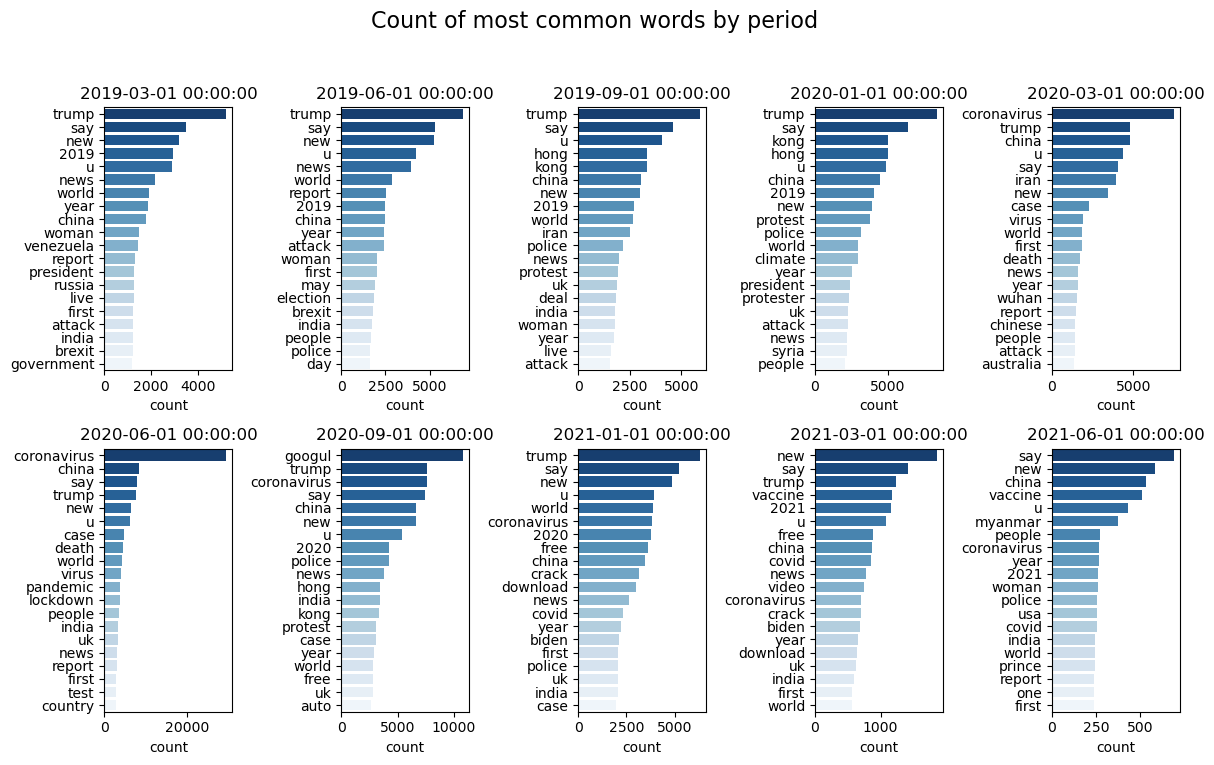

In [29]:
words = postsFromCSV("words.csv")
datas = []

for i in range(len(date_limits)):
    period = words[words['period'] == i]  
    counts = period['word'].value_counts().head(20) 

    counts_ascending = counts.sort_values(ascending=False)
    datas.append(counts_ascending)
#plt.show()

COUNT = len(datas)

fig, axes = plt.subplots(2, int(COUNT/2), figsize=(12, 8)) 
barplots = []
for i in range(COUNT):
    data = datas[i]
    row = int(i / int(COUNT/2))
    col = i - row * int(COUNT/2)
    barplots.append(sns.barplot(x=data, y=data.index, ax=axes[row, col], palette='Blues_r'))
    axes[row, col].set_title(date_limits[i])

# Set y-axis labels to be more readable
for ax in axes.flat:
    ax.set_ylabel('')

# Set overall plot title and adjust spacing
plt.suptitle('Count of most common words by period', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [30]:
words = postsFromCSV("words.csv")

datas = []

for i in range(COUNT):
    period = words[words['period'] == i]  # filter to keep only singular nouns
    counts = period['word'].value_counts().head(20)  # count noun occurrences

    counts_ascending = counts.sort_values(ascending=True) # We sort the values in ascending order first, feels more natural to see the lowest values at the bottom, highest at the top
    #print(i, len(counts_ascending))
    #counts_ascending.plot(kind='barh')  # We use barh instead of bar to switch to horizontal view
    datas.append(counts_ascending)
#plt.show()

# Let's count the occurrences of each word - this is a prerequisite for finding term frequency
count_words = words.groupby(['word', 'period']).size().sort_values(ascending=False).reset_index(name='count')
count_period = words.groupby(['period']).size().sort_values(ascending=False).reset_index(name='count')
df = count_words.merge(count_period, on='period')

df = df.rename(columns={'count_x': 'count_word', 'count_y': 'count_period'}) # Give more meaningful names
df['tf'] = df['count_word'] / df['count_period'] * 1000

postsToCSV(df, "tf.csv")

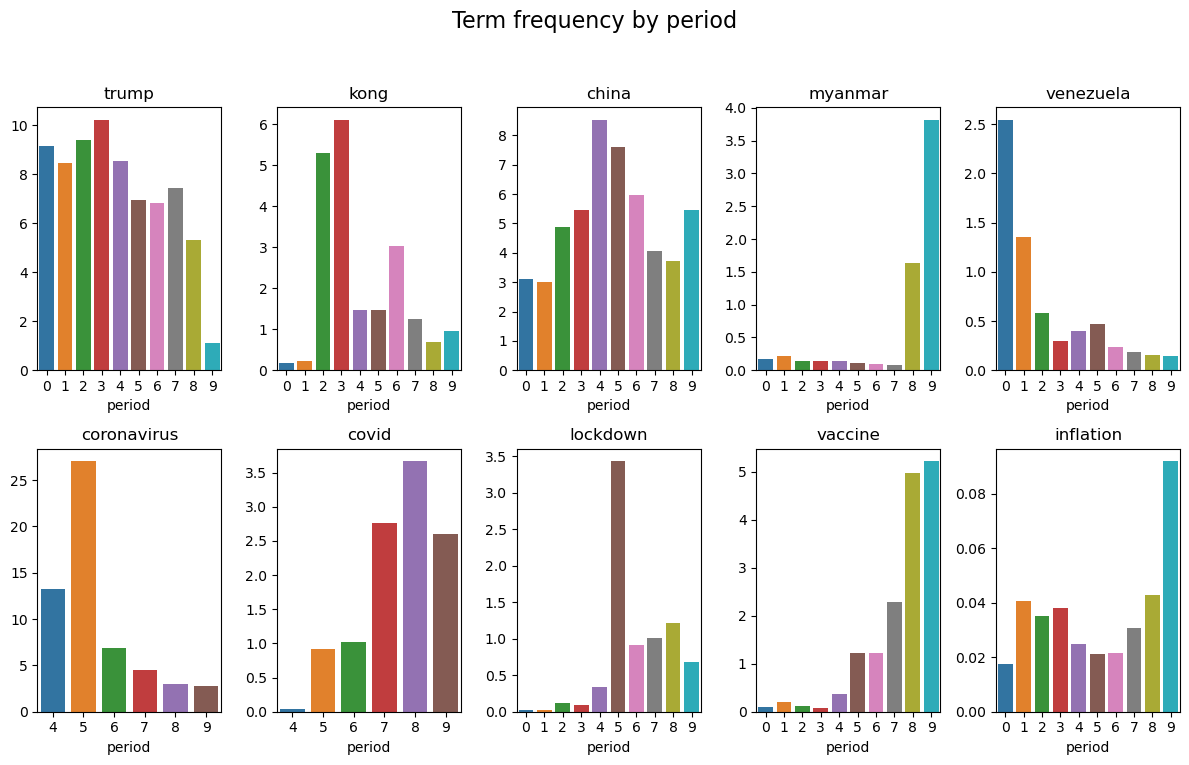

In [31]:
topics = [
        'trump',
        'kong',
        'china',
        'myanmar',
        'venezuela',
        'coronavirus',
        'covid',
        'lockdown',
        'vaccine',
        'inflation',
    ]

fig, axes = plt.subplots(2, int(COUNT/2), figsize=(12, 8)) # Our figure will be comprised of 2 x 2 subplots
barplots = []
for i in range(COUNT):
    data = df[df['word'] == topics[i]]
    row = int(i / int(COUNT/2))
    col = i - row * int(COUNT/2)
    barplots.append(sns.barplot(x=data['period'], y=data['tf'], ax=axes[row, col]))
    axes[row, col].set_title(topics[i])

# Set y-axis labels to be more readable
for ax in axes.flat:
    ax.set_ylabel('')

# Set overall plot title and adjust spacing
plt.suptitle('Term frequency by period', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

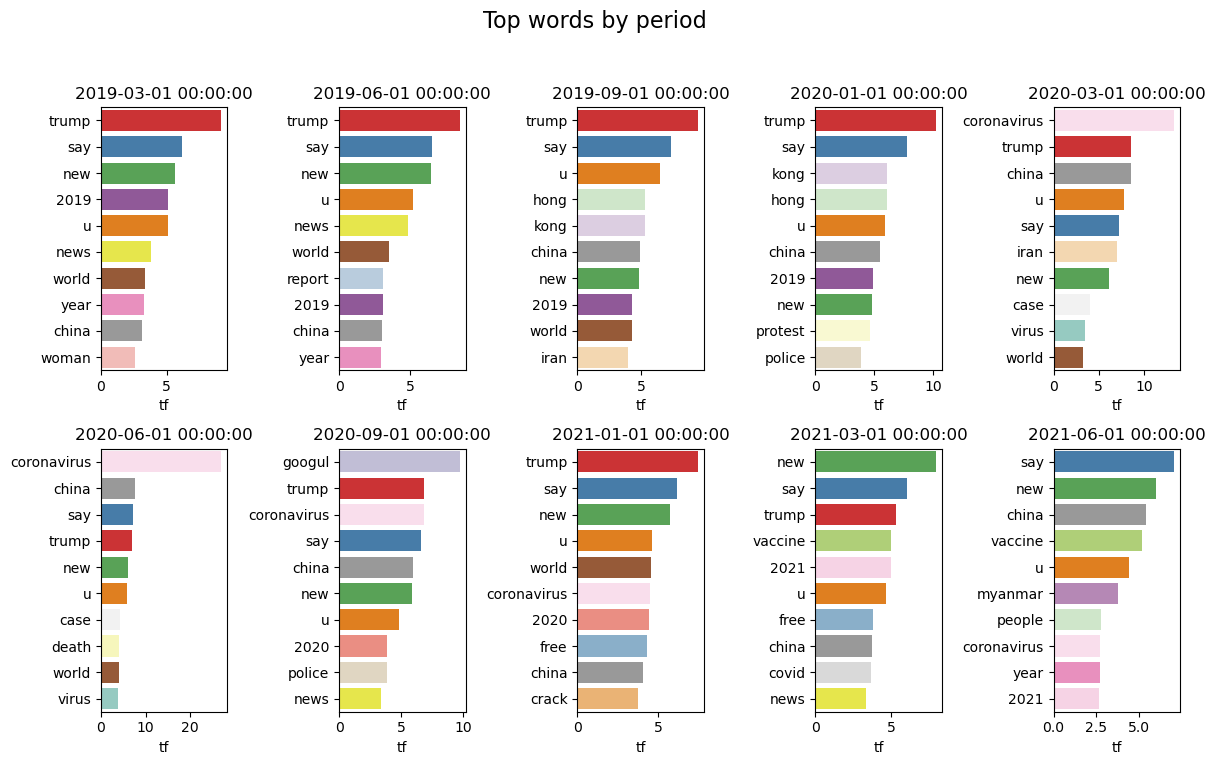

In [33]:
palette = sns.color_palette("Set1")
palette.extend(sns.color_palette("Pastel1"))
palette.extend(sns.color_palette("Set3"))
palette.extend(sns.color_palette("Pastel2"))
palette.extend(sns.color_palette("Dark2"))
palette.extend(sns.color_palette("Accent"))
palette.extend(sns.color_palette("Set2"))
colorindex = 0
colormap = dict()

fig, axes = plt.subplots(2, int(COUNT/2), figsize=(12, 8)) # Our figure will be comprised of 2 x 2 subplots
barplots = []
for i in range(COUNT):
    data = df[df['period'] == i].sort_values(ascending=False, by='tf')
    data = data.head(10)

    local_pallete = sns.color_palette(n_colors=0)

    for k in range(10):
        word = data.iloc[k]['word']
        #print(word)
        if word not in colormap:
            colormap[word] = palette[colorindex]
            colorindex += 1
        local_pallete.append(colormap[word])

    row = int(i / int(COUNT/2))
    col = i - row * int(COUNT/2)
    barplots.append(sns.barplot(x=data['tf'], y=data['word'], ax=axes[row, col], palette=local_pallete))
    axes[row, col].set_title(date_limits[i])

# Set y-axis labels to be more readable
for ax in axes.flat:
    ax.set_ylabel('')

# Set overall plot title and adjust spacing
plt.suptitle('Top words by period', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:

words = postsFromCSV("tf.csv")


#words = words.head(200)
unique = words[words['count_word'] >= 3600]['word'].unique()

#print(words)
#print(len(words))
#print(len(unique))
#print(unique)

top = [ [] for _ in range(len(unique))]
df = pd.DataFrame({"period": range(COUNT)})

#print(df)

for i,word in enumerate(unique):
    for period in range(COUNT):
        try:
            val = float(words.loc[(words['period'] == period) & (words['word'] == word)]['tf'])
        except:
            val = 0
        top[i].append(val) #words[words['period'] == period]['word' == word]

print(top)

for i,word in enumerate(unique):
    df[word] = pd.DataFrame(top[i])
print(df)

[[0, 0, 0, 0, 13.297489574689994, 27.02029726354952, 6.838733395202038, 4.49577835447202, 2.9881755456947188, 2.725435355123206], [3.093680229323229, 3.0081386589982846, 4.881031816683414, 5.461400059810665, 8.530364437210938, 7.604607987813586, 5.969881597647197, 4.054807700243712, 3.723463376681116, 5.450870710246412], [6.167991942697365, 6.51681588768307, 7.322343978176294, 7.753325129794045, 7.1942190390058505, 7.137730646561036, 6.638780917539777, 6.173589159196301, 6.061849676387856, 7.0840903987097565], [9.163068818097942, 8.457629655438081, 9.416489765758248, 10.224191943209284, 8.532141226304297, 6.954641493128664, 6.842319986729612, 7.450517550985758, 5.300912269901933, 1.1228385358185493], [5.609826528528063, 6.4211246905371215, 4.795036476356855, 4.803237619927737, 6.165458153951668, 5.965960064593853, 5.916979372615477, 5.71375345024165, 7.942818546353057, 6.00208235510279], [5.081594275370995, 5.168551456101049, 6.452835537096638, 5.918559445427671, 7.759237970693641, 5.7

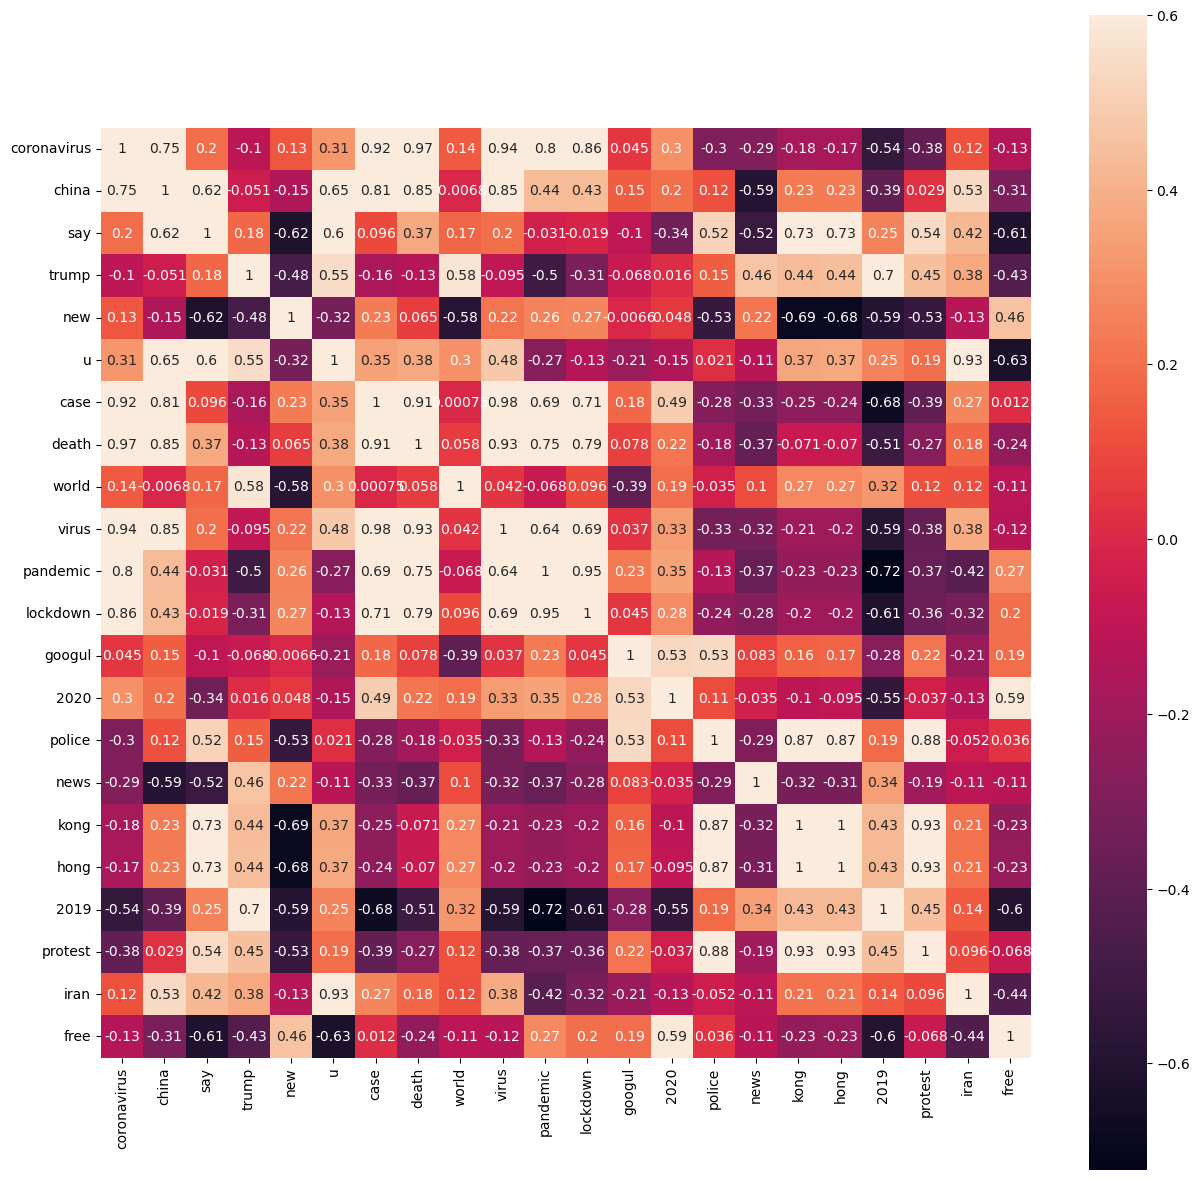

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
correlation = df.drop('period', axis=1).corr()
foo = sns.heatmap(correlation, vmax=0.6, square=True, annot=True, ax=ax)

In [30]:
s = correlation.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
print(so[len(unique):len(unique)+40:2])

kong         hong           0.999944
virus        case           0.978605
coronavirus  death          0.972266
lockdown     pandemic       0.953508
virus        coronavirus    0.941933
             death          0.934406
hong         protest        0.926071
protest      kong           0.925893
u            iran           0.925603
case         coronavirus    0.924557
death        case           0.908952
police       protest        0.880733
             hong           0.872954
             kong           0.871384
coronavirus  lockdown       0.861640
death        china          0.847456
virus        china          0.845418
china        case           0.813098
pandemic     coronavirus    0.799015
lockdown     death          0.787919
dtype: float64


In [31]:

so = s.sort_values(kind="quicksort", ascending=True)
print(so[0:40:2])

pandemic     2019    -0.721972
new          kong    -0.685056
             hong    -0.684483
case         2019    -0.679949
free         u       -0.626075
say          new     -0.616766
lockdown     2019    -0.612118
say          free    -0.609697
2019         free    -0.595041
new          2019    -0.591256
news         china   -0.588300
virus        2019    -0.586456
new          world   -0.580486
2019         2020    -0.545041
coronavirus  2019    -0.538709
protest      new     -0.529348
police       new     -0.526869
say          news    -0.517573
2019         death   -0.509578
pandemic     trump   -0.500205
dtype: float64
